In [3]:
import os
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
PHONEMES = "bviuo"
CLASSES = len(PHONEMES)+1

# Get phoneme characters
def phoneme(index):
    if index == 0:
        return "_"
    else:
        return PHONEMES[index-1]

def get_files_with_prefix(directory, prefix):
    files = os.listdir(directory)
    filtered_files = [file for file in files if file.startswith(prefix)]
    return filtered_files

directory = "/content"
X_filename = get_files_with_prefix(directory, f"X_{PHONEMES}")[0]
y_filename = get_files_with_prefix(directory, f"y_{PHONEMES}")[0]

print(f"X_filename: {X_filename}")
print(f"y_filename: {y_filename}")

X_filename: X_bviuo_3676_4_10_5.npy
y_filename: y_bviuo_3676_4_10_5.npy


In [5]:
def parse_filename(filename):
    # Regular expression pattern to extract the required information from the filename
    pattern = r"X_bviuo_(\d+)_(\d+)_(\d+)_\d+.npy"

    # Use regular expression to search and extract the required information
    match = re.search(pattern, filename)

    if match:
        num_examples = int(match.group(1))
        channels = int(match.group(2))
        size = int(match.group(3))

        return num_examples, channels, size
    else:
        raise ValueError("Invalid filename format")

NUM_EXAMPLES, CHANNELS, SIZE = parse_filename(X_filename)

print("NUM_EXAMPLES:", NUM_EXAMPLES)
print("channels:", CHANNELS)
print("size:", SIZE)

NUM_EXAMPLES: 3676
channels: 4
size: 10


In [6]:
# Load the training data
X_train_og = np.load(X_filename)
y_train_og = np.load(y_filename)

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_train_og, y_train_og, test_size=0.2, random_state=42)

# Prepare the data - N training examples, 4 channels (muscle groups) per example, each 100 timesteps long
X_train = X_train.reshape(-1, CHANNELS, SIZE)
X_test = X_test.reshape(-1, CHANNELS, SIZE)

print(f"X_train.shape: {X_train.shape} - {X_train.shape[0]} training examples")
print(f"X_test.shape: {X_test.shape} - {X_test.shape[0]} testing examples")

X_train.shape: (2940, 4, 10) - 2940 training examples
X_test.shape: (736, 4, 10) - 736 testing examples


In [7]:
# Count the occurrences of each class in the training set
y_og_counts = Counter(y_train_og)

# Count the occurrences of each class in the training set
y_train_counts = Counter(y_train)

# Count the occurrences of each class in the test set
y_test_counts = Counter(y_test)

# Print the occurrences
print("Occurrences in the original set:")
for phoneme_index, count in sorted(y_og_counts.items()):
    print(f"\tPhoneme {phoneme(phoneme_index)}: {count}")

print("Occurrences in the training set:")
for phoneme_index, count in sorted(y_train_counts.items()):
    print(f"\tPhoneme {phoneme(phoneme_index)}: {count}")

print("Occurrences in the test set:")
for phoneme_index, count in sorted(y_test_counts.items()):
    print(f"\tPhoneme {phoneme(phoneme_index)}: {count}")

Occurrences in the original set:
	Phoneme _: 649
	Phoneme b: 367
	Phoneme v: 718
	Phoneme i: 669
	Phoneme u: 638
	Phoneme o: 635
Occurrences in the training set:
	Phoneme _: 496
	Phoneme b: 301
	Phoneme v: 575
	Phoneme i: 544
	Phoneme u: 523
	Phoneme o: 501
Occurrences in the test set:
	Phoneme _: 153
	Phoneme b: 66
	Phoneme v: 143
	Phoneme i: 125
	Phoneme u: 115
	Phoneme o: 134


In [8]:
model = tf.keras.Sequential([
    layers.Conv1D(32, 3, activation='relu', input_shape=(CHANNELS, SIZE)),
    layers.Conv1D(64, 1, activation='relu'),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(CLASSES, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             992       
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             2112      
                                                                 
 lstm (LSTM)                 (None, 2, 128)            98816     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 155,878
Trainable params: 155,878
Non-trai

In [9]:
# Define Early Stopping callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=100,
    mode='max',
    restore_best_weights=True
)

In [10]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=500,
    verbose=1,
    validation_data=(X_test, y_test),
    callbacks=[callback]
)

Epoch 1/500
23/23 [==============================] - 10s 66ms/step - loss: 1.7634 - accuracy: 0.3344 - val_loss: 1.6859 - val_accuracy: 0.3764
Epoch 2/500
23/23 [==============================] - 0s 17ms/step - loss: 1.3621 - accuracy: 0.4310 - val_loss: 0.8696 - val_accuracy: 0.6929
Epoch 3/500
23/23 [==============================] - 0s 18ms/step - loss: 0.7344 - accuracy: 0.7024 - val_loss: 0.5988 - val_accuracy: 0.7677
Epoch 4/500
23/23 [==============================] - 0s 19ms/step - loss: 0.6509 - accuracy: 0.7293 - val_loss: 0.5808 - val_accuracy: 0.7486
Epoch 5/500
23/23 [==============================] - 0s 17ms/step - loss: 0.5897 - accuracy: 0.7558 - val_loss: 0.5796 - val_accuracy: 0.7745
Epoch 6/500
23/23 [==============================] - 0s 17ms/step - loss: 0.5767 - accuracy: 0.7646 - val_loss: 0.4888 - val_accuracy: 0.8125
Epoch 7/500
23/23 [==============================] - 0s 17ms/step - loss: 0.5260 - accuracy: 0.7895 - val_loss: 0.5009 - val_accuracy: 0.8057
Epoch

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Example Count: {len(y_test)}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Example Count: 736
Test Loss: 0.0156968105584383
Test Accuracy: 0.9972826242446899


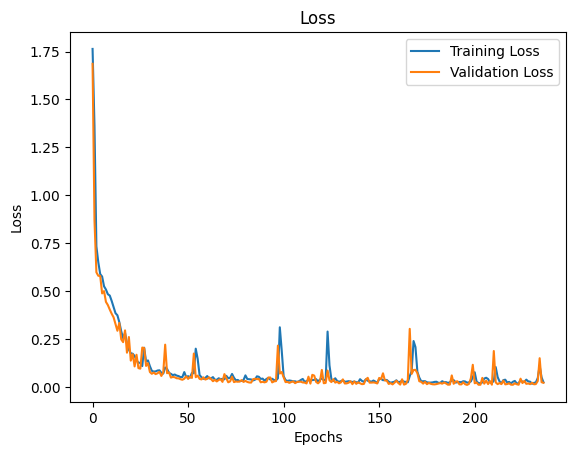

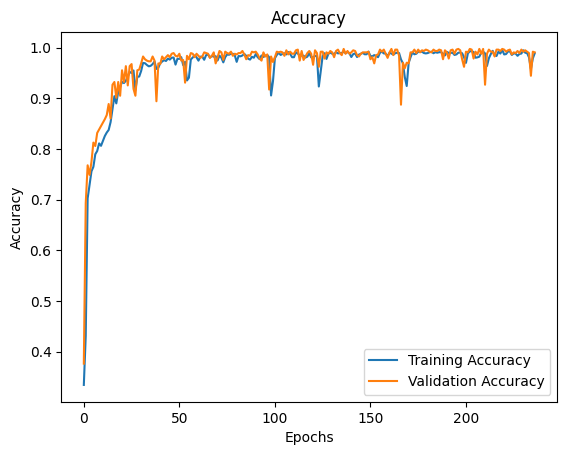

In [12]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

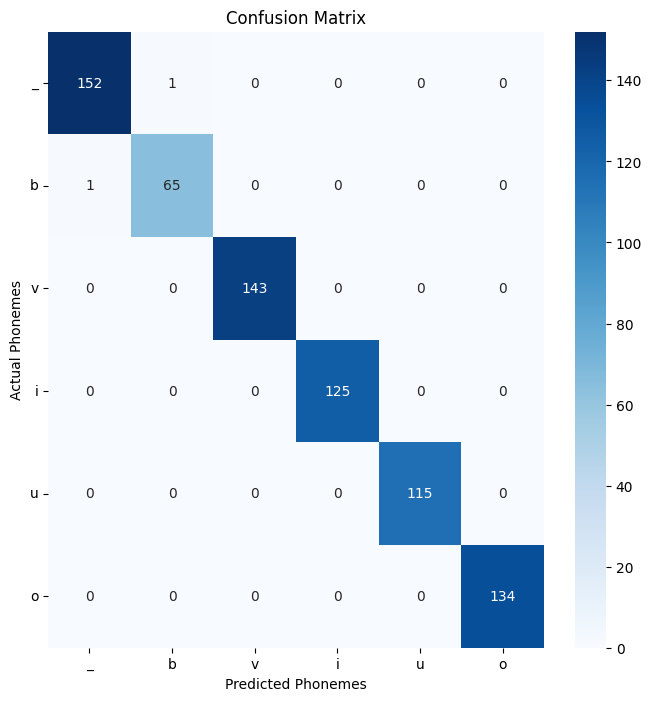

In [13]:
# Get the predicted classes for the entire test set
y_predicted = model.predict(X_test, verbose=0)
y_predicted_classes = np.argmax(y_predicted, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_predicted_classes)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(
                      cm,
                      annot=True,
                      cmap="Blues",
                      fmt='d',  # <- Set integer format for the annotations
                      xticklabels=[phoneme(i) for i in range(CLASSES)],
                      yticklabels=[phoneme(i) for i in range(CLASSES)],
)

# Modify the rotation of the y-axis labels
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Phonemes")
plt.ylabel("Actual Phonemes")
plt.show()

In [14]:
# Choose 10 random examples from the test set
random_indices = random.sample(range(X_test.shape[0]), 10)
random_X = X_test[random_indices]
random_y_actual = y_test[random_indices]

# Predict the phoneme using the model
predictions = model.predict(random_X, verbose=0)
random_y_predicted = np.argmax(predictions, axis=1)

# Show actual and predicted phoneme for each picked example
for i in range(10):
    print(f"Example {i + 1}:")
    print(f"\tActual Phoneme: {phoneme(random_y_actual[i])}")
    print(f"\tPredicted Phoneme: {phoneme(random_y_predicted[i])}")

Example 1:
	Actual Phoneme: i
	Predicted Phoneme: i
Example 2:
	Actual Phoneme: _
	Predicted Phoneme: _
Example 3:
	Actual Phoneme: o
	Predicted Phoneme: o
Example 4:
	Actual Phoneme: u
	Predicted Phoneme: u
Example 5:
	Actual Phoneme: i
	Predicted Phoneme: i
Example 6:
	Actual Phoneme: o
	Predicted Phoneme: o
Example 7:
	Actual Phoneme: _
	Predicted Phoneme: _
Example 8:
	Actual Phoneme: b
	Predicted Phoneme: b
Example 9:
	Actual Phoneme: _
	Predicted Phoneme: _
Example 10:
	Actual Phoneme: o
	Predicted Phoneme: o
